<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/SAM/Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook: fine-tune SAM (segment anything) on a custom dataset

In this notebook, we'll reproduce the [MedSAM](https://github.com/bowang-lab/MedSAM) project, which fine-tunes [SAM](https://huggingface.co/docs/transformers/main/en/model_doc/sam) on a dataset of medical images. For demo purposes, we'll use a toy dataset, but this can easily be scaled up.

Resources used to create this notebook (thanks 🙏):
* [Encode blog post](https://encord.com/blog/learn-how-to-fine-tune-the-segment-anything-model-sam/)
* [MedSAM repository](https://github.com/bowang-lab/MedSAM).

## Set-up environment

We first install 🤗 Transformers and 🤗 Datasets.

In [1]:
import sys
import os

In [ ]:
!git clone https://github.com/SysCV/sam-hq/
!pip install -e sam-hq
!pip install -q datasets
!pip install -q monai
!pip install opencv-python pycocotools matplotlib onnxruntime onnx ipykernel timm
!wget https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_l.pth
!wget https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_h.pth
!mkdir pretrained_checkpoint
!mv sam_hq_vit_h.pth pretrained_checkpoint
!mv sam_hq_vit_l.pth pretrained_checkpoint
sys.path.append(os.path.join(os.getcwd(), "sam-hq"))

!pip install gdown
!gdown 15ccaDbz7woXub_zpszqkfy5D-iimJ0_w
!unzip train.zip > /dev/null
!mkdir result
!gdown 1MW9h_z945ExeQEWuMluEXiZHwAo3IoQF
!unzip test > /dev/null

## Load dataset

Here we load a small dataset of 130 (image, ground truth mask) pairs.

To load your own images and masks, refer to the bottom of my [SAM inference notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Run_inference_with_MedSAM_using_HuggingFace_Transformers.ipynb).

See also [this guide](https://huggingface.co/docs/datasets/image_dataset). 

We can visualize an example:

In [2]:
import torch
from torch import nn
import random
from PIL import Image
import glob
import numpy as np
import cv2
import os
from tqdm.auto import tqdm
from datasets import Dataset
import gc
from matplotlib import pyplot as plt




def load_and_process_images(img_dir):
    images = glob.glob(img_dir)
    data = {'image':[], 'label':[]}
    c = 0
    
    for f in tqdm(images):
        img = cv2.imread(f, cv2.IMREAD_UNCHANGED)
        try:
            r, g, b, a = cv2.split(img)
        except Exception as e:
            c += 1
            os.remove(f)
    
    for img_path in tqdm(images):
        try:
            im = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            im = cv2.resize(im, (256, 256))
        except:
            os.remove(img_path)
            c += 1
            continue
        ret, mask = cv2.threshold(im[:, :, 3], 0, 255, cv2.THRESH_BINARY)
        mask[mask == 255] = 1
        mask[mask == 0] = 0
        rgb_im = cv2.cvtColor(im, cv2.COLOR_RGBA2RGB)
        data['image'].append(Image.fromarray(rgb_im))
        data['label'].append(Image.fromarray(mask))
    
    print(f'{c} removed')

    return data

img_dir = "downloaded/*/*.webp"
processed_data = load_and_process_images(img_dir)

  0%|          | 0/7658 [00:00<?, ?it/s]

  0%|          | 0/7658 [00:00<?, ?it/s]

0 removed


In [ ]:
dataset = Dataset.from_dict(processed_data)
dataset

del processed_data
gc.collect()

24

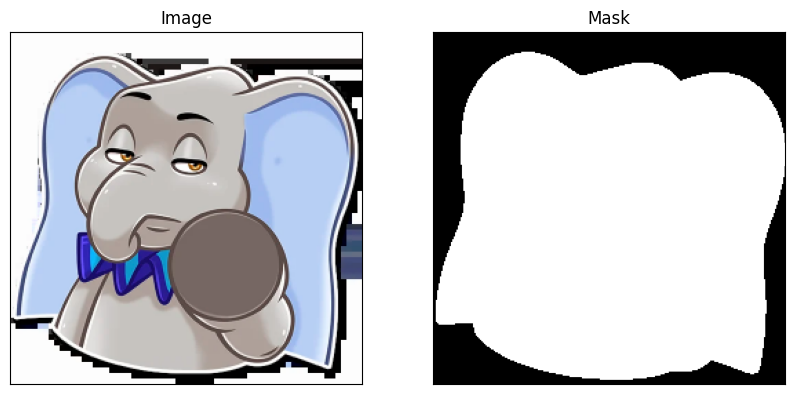

In [ ]:
img_num = random.randint(0, len(dataset) -1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image))  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

## Create PyTorch dataset

Below we define a regular PyTorch dataset, which gives us examples of the data prepared in the format for the model. Each example consists of:

* pixel values (which is the image prepared for the model)
* a prompt in the form of a bounding box
* a ground truth segmentation mask.

The function below defines how to get a bounding box prompt based on the ground truth segmentation. This was taken from [here](https://github.com/bowang-lab/MedSAM/blob/66cf4799a9ab9a8e08428a5087e73fc21b2b61cd/train.py#L29).

Note that SAM is always trained using certain "prompts", which you could be bounding boxes, points, text, or rudimentary masks. The model is then trained to output the appropriate mask given the image + prompt.

In [9]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [10]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [11]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

In [12]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [13]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


## Create PyTorch DataLoader

Next we define a PyTorch Dataloader, which allows us to get batches from the dataset.



In [14]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=True)

In [15]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [16]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

## Load the model

In [17]:
from transformers import SamModel 

model = SamModel.from_pretrained("facebook/sam-vit-huge")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

## Train the model

In [18]:
from torch.optim import AdamW
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = AdamW(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [19]:
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print('load sam')

load sam


In [20]:
'''from segment_anything import build_sam_vit_h, build_sam_vit_l, SamPredictor

sam_checkpoint = 'pretrained_checkpoint/sam_hq_vit_h.pth'




sam = build_sam_vit_h(checkpoint=sam_checkpoint) if 'vit_h' in sam_checkpoint else build_sam_vit_l(checkpoint=sam_checkpoint)
sam.to(device='cuda')
sam_predictor = SamPredictor(sam)
sam

for name, param in sam.named_parameters():
  if name.startswith("image_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)'''

'from segment_anything import build_sam_vit_h, build_sam_vit_l, SamPredictor\n\nsam_checkpoint = \'pretrained_checkpoint/sam_hq_vit_h.pth\'\n\n\n\n\nsam = build_sam_vit_h(checkpoint=sam_checkpoint) if \'vit_h\' in sam_checkpoint else build_sam_vit_l(checkpoint=sam_checkpoint)\nsam.to(device=\'cuda\')\nsam_predictor = SamPredictor(sam)\nsam\n\nfor name, param in sam.named_parameters():\n  if name.startswith("image_encoder") or name.startswith("prompt_encoder"):\n    param.requires_grad_(False)'

In [ ]:
model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

## Inference

Important note here: as we used the Dice loss with `sigmoid=True`, we need to make sure to appropriately apply a sigmoid activation function to the predicted masks. Hence we won't use the processor's `post_process_masks` method here.

In [ ]:
1/0

In [ ]:
import numpy as np
from PIL import Image

# let's take a random training example
idx = 10

# load image
image = dataset[idx]["image"]
image

In [ ]:
# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

In [ ]:
model.eval()

# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

In [ ]:
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(medsam_seg, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

Compare this to the ground truth segmentation:

In [ ]:
fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(ground_truth_mask, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")